In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
# from functions import create_dataset

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [2]:
df = pd.read_csv("datasets/nasd_input.csv", header=None, sep='\t')
# df.head()

In [3]:
train_size = int(len(df.columns) * 0.9)
test_size = len(df.columns) - train_size
train, test = df.iloc[0, 1:train_size].values.reshape(-1, 1), df.iloc[0, train_size:len(df.columns)].values.reshape(-1, 1)
print(train.shape, test.shape)

(656, 1) (74, 1)


In [4]:
scaler = StandardScaler()
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [5]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)        
        ys.append(y[i + time_steps])
    return np.array(Xs).astype('float32'), np.array(ys).astype('float32')

In [6]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train_scaled, TIME_STEPS)
X_test, y_test = create_dataset(test, test_scaled, TIME_STEPS)

print(X_train.shape)

(626, 30, 1)


In [7]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [8]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
18/18 [==============================] - 2s 116ms/step - loss: 0.6211 - val_loss: 1.9309
Epoch 2/10
18/18 [==============================] - 0s 26ms/step - loss: 0.8429 - val_loss: 2.1627
Epoch 3/10
18/18 [==============================] - 0s 24ms/step - loss: 0.7118 - val_loss: 2.3914
Epoch 4/10
18/18 [==============================] - 0s 24ms/step - loss: 0.6357 - val_loss: 2.3834
Epoch 5/10
18/18 [==============================] - 0s 25ms/step - loss: 0.6033 - val_loss: 2.3062
Epoch 6/10
18/18 [==============================] - 0s 24ms/step - loss: 0.5655 - val_loss: 2.1450
Epoch 7/10
18/18 [==============================] - 0s 25ms/step - loss: 0.5367 - val_loss: 1.9585
Epoch 8/10
18/18 [==============================] - 0s 24ms/step - loss: 0.4051 - val_loss: 1.5109
Epoch 9/10
18/18 [==============================] - 0s 23ms/step - loss: 0.5075 - val_loss: 1.3276
Epoch 10/10
18/18 [==============================] - 0s 23ms/step - loss: 0.2905 - val_loss: 1.1622


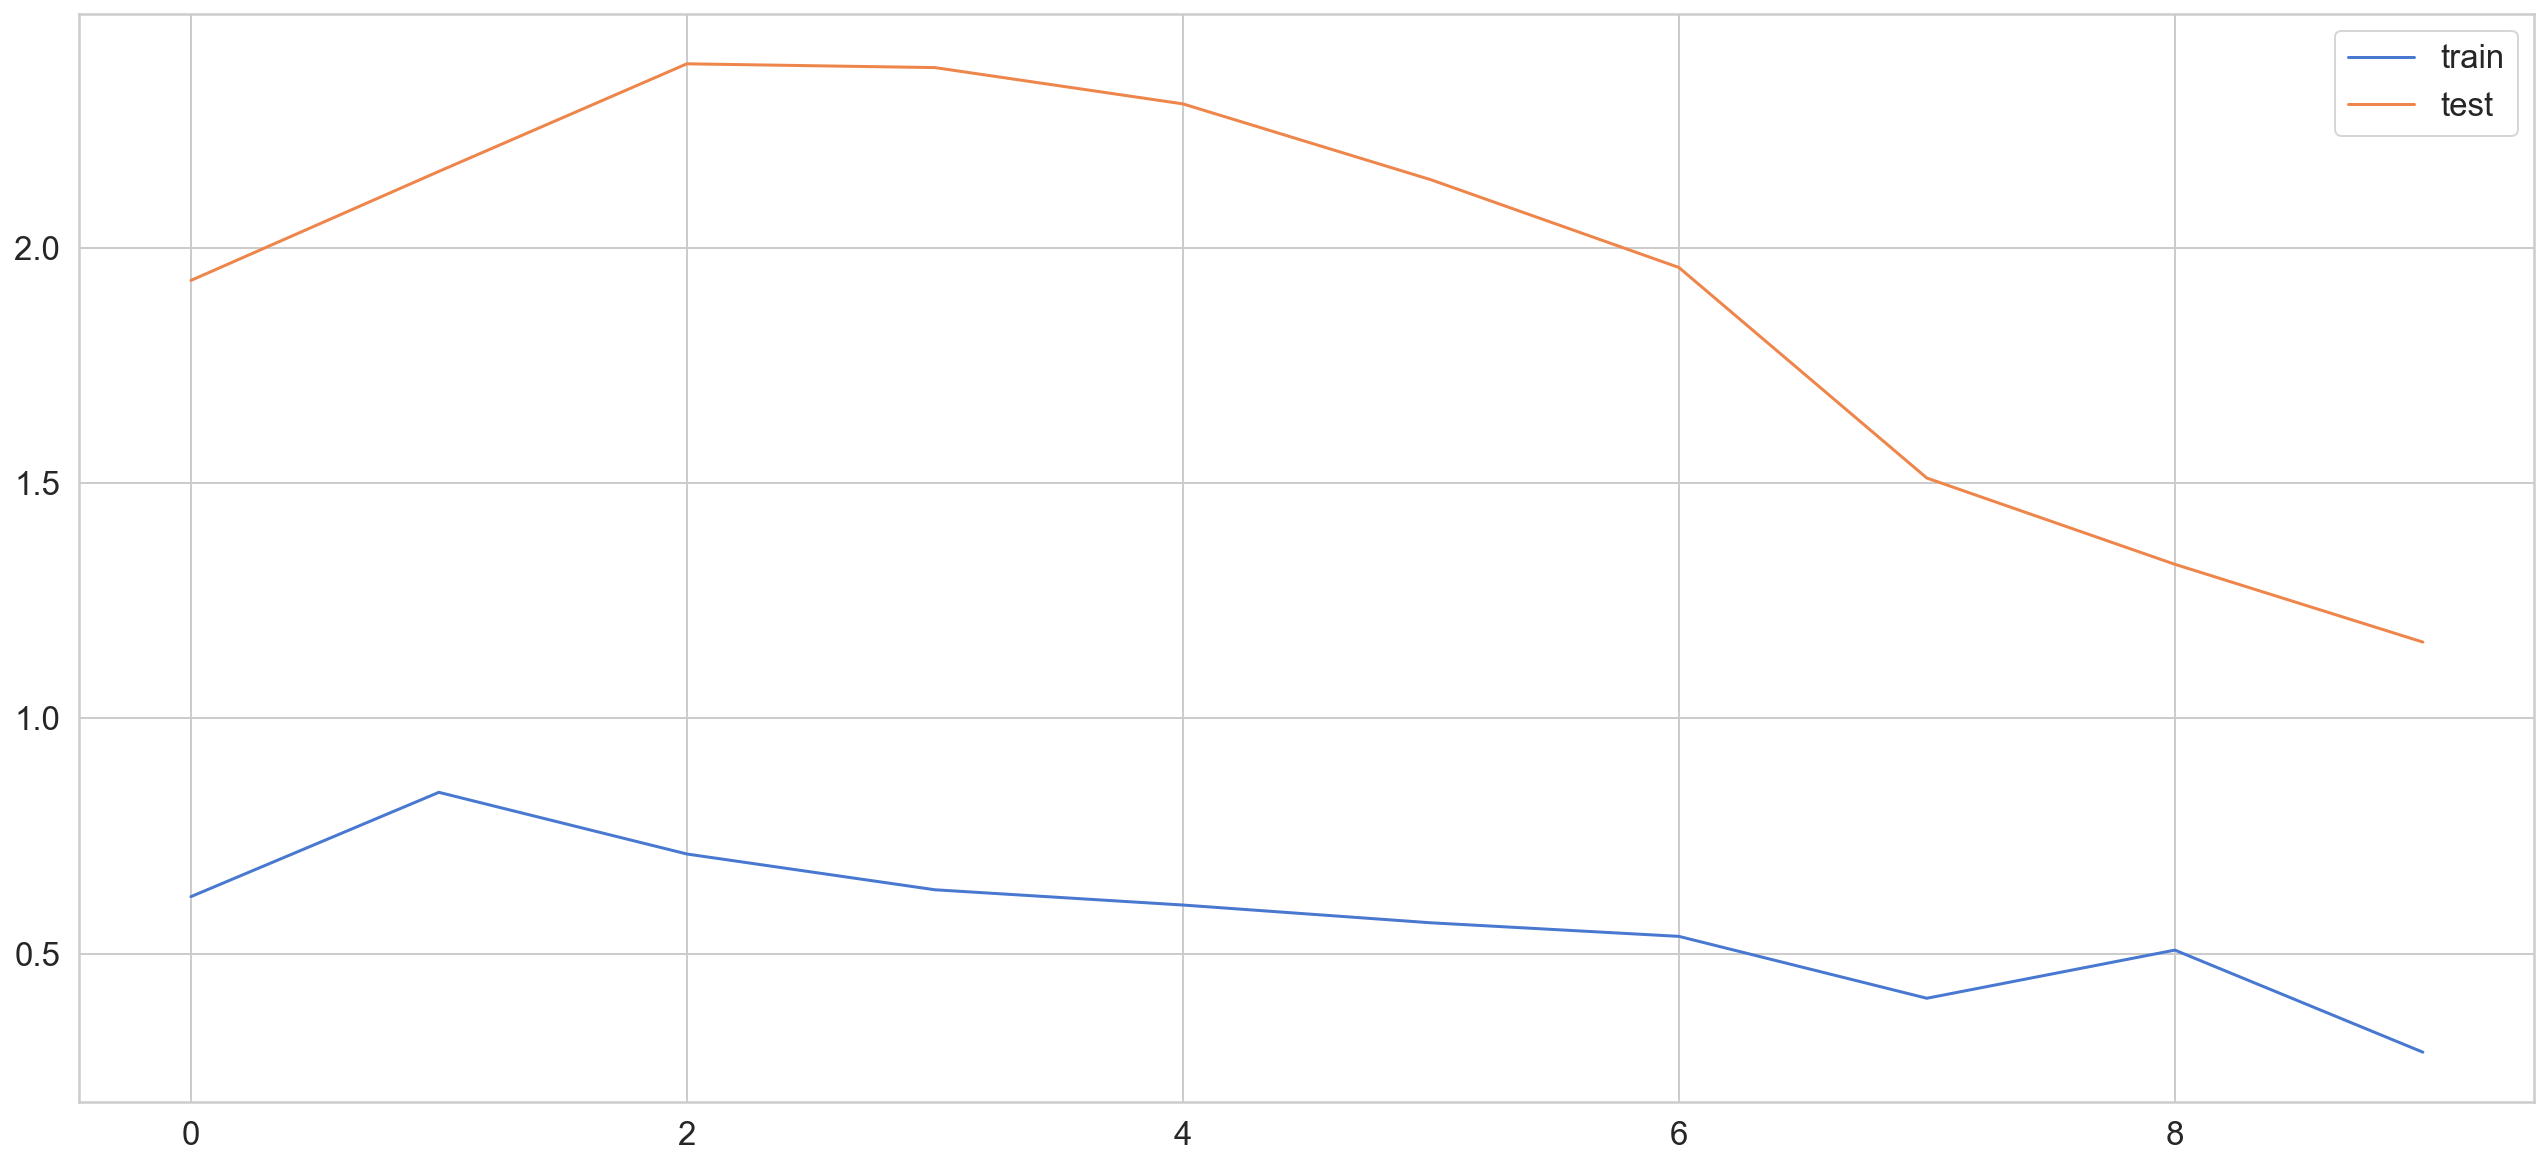

In [9]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [10]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

C:\Users\user\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


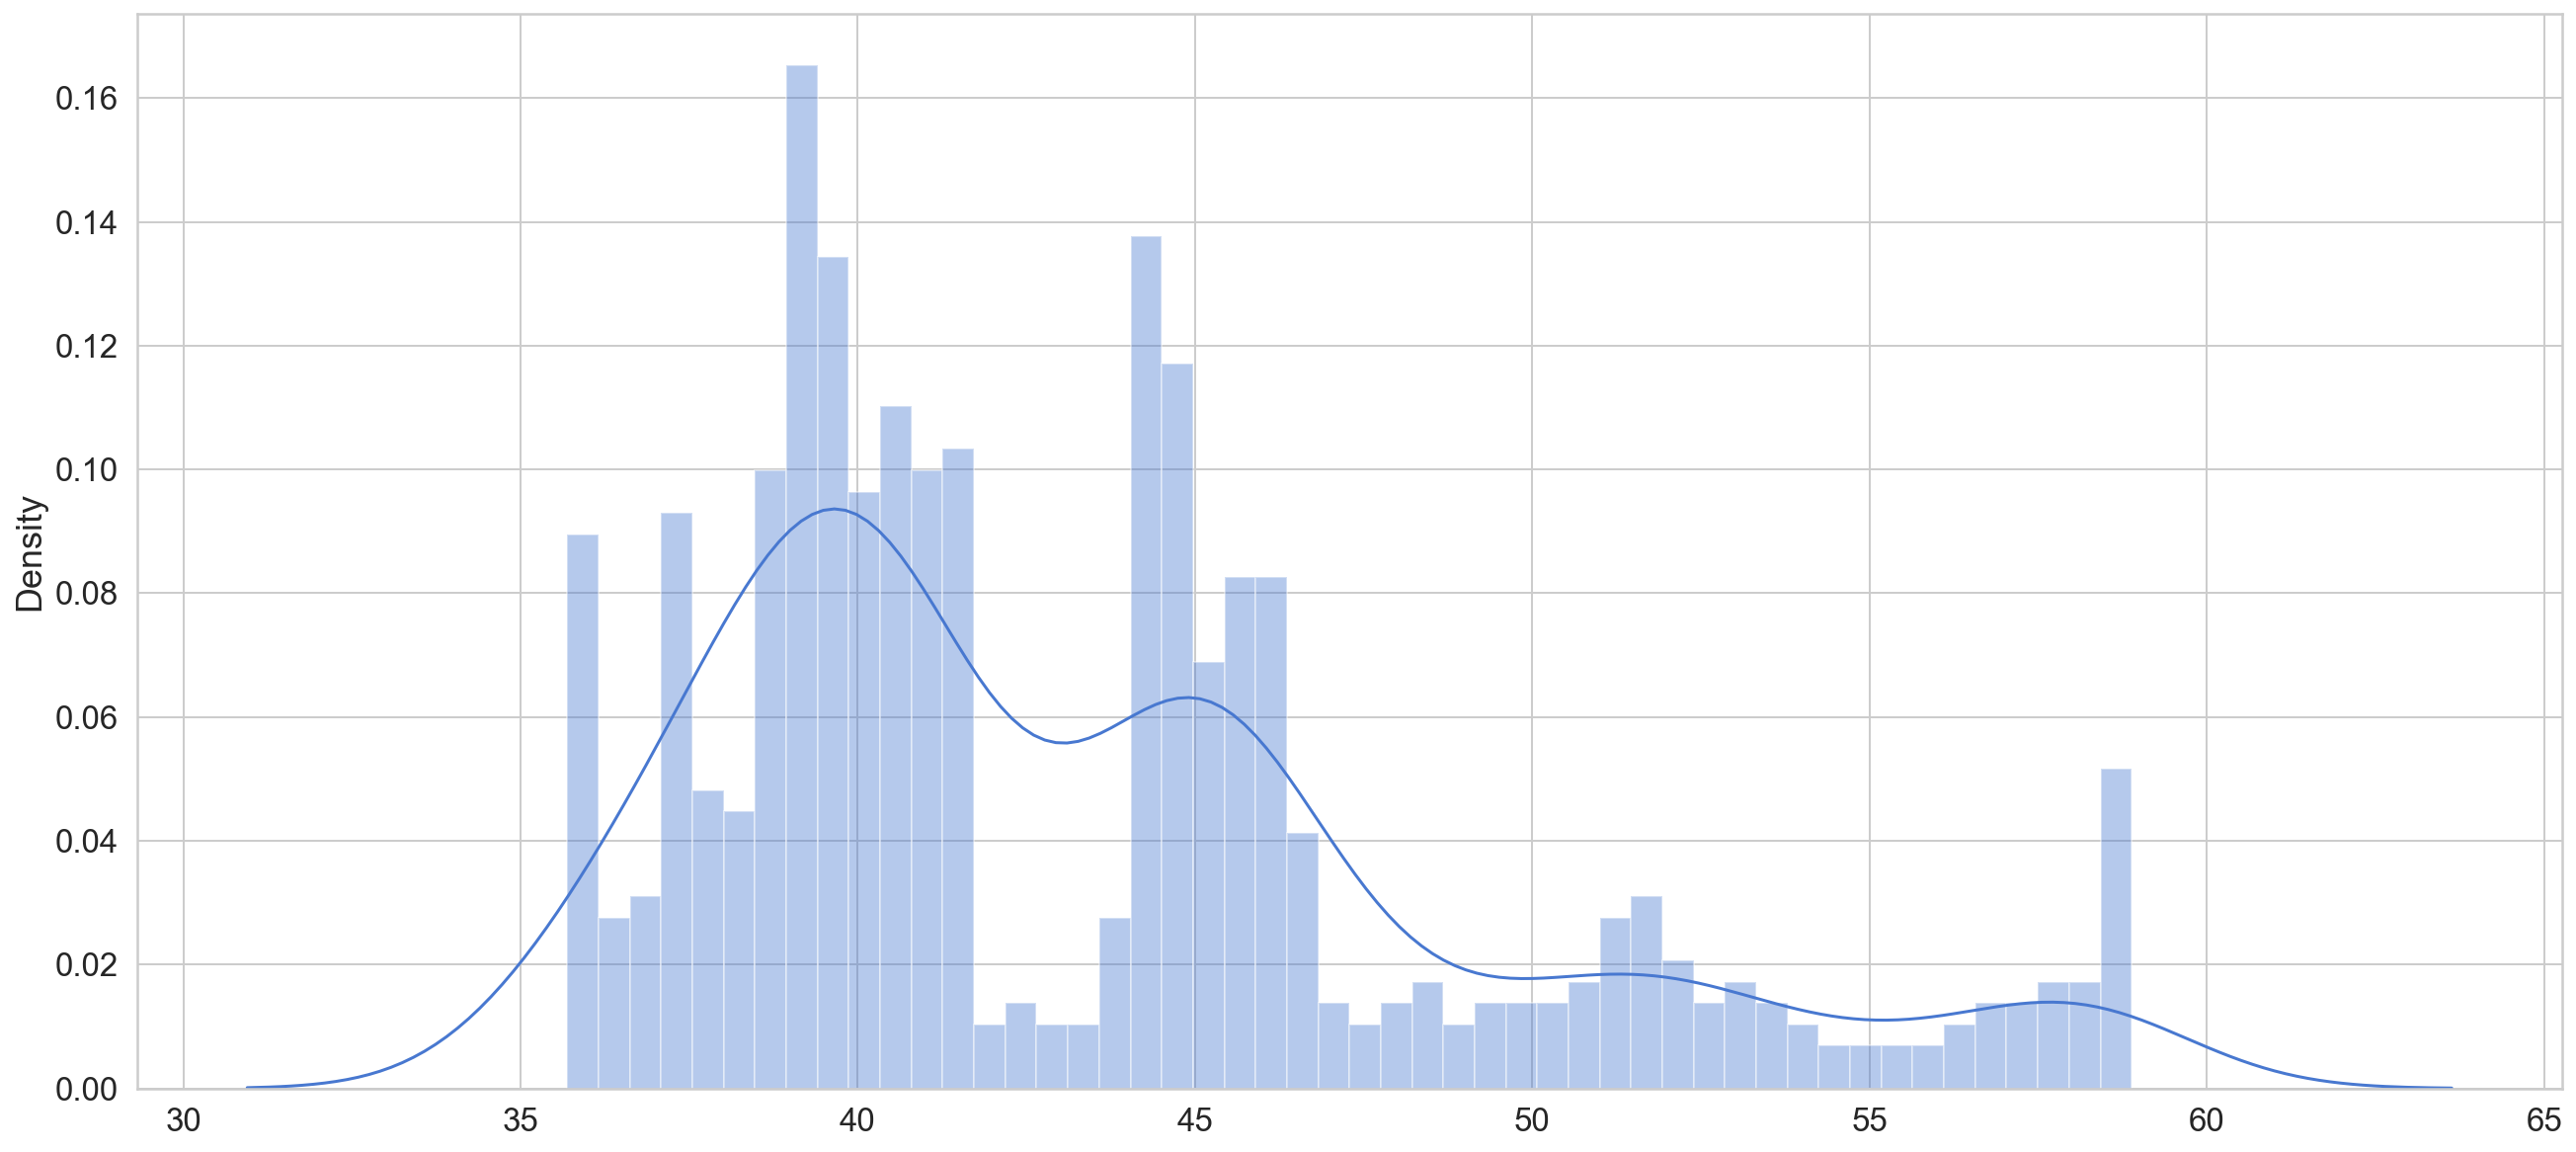

In [11]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [12]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [13]:
THRESHOLD = 65

time_array = np.array([x for x in range(len(df.columns))])

test_score_df = pd.DataFrame(index=time_array[train_size + TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test_scaled[TIME_STEPS:]


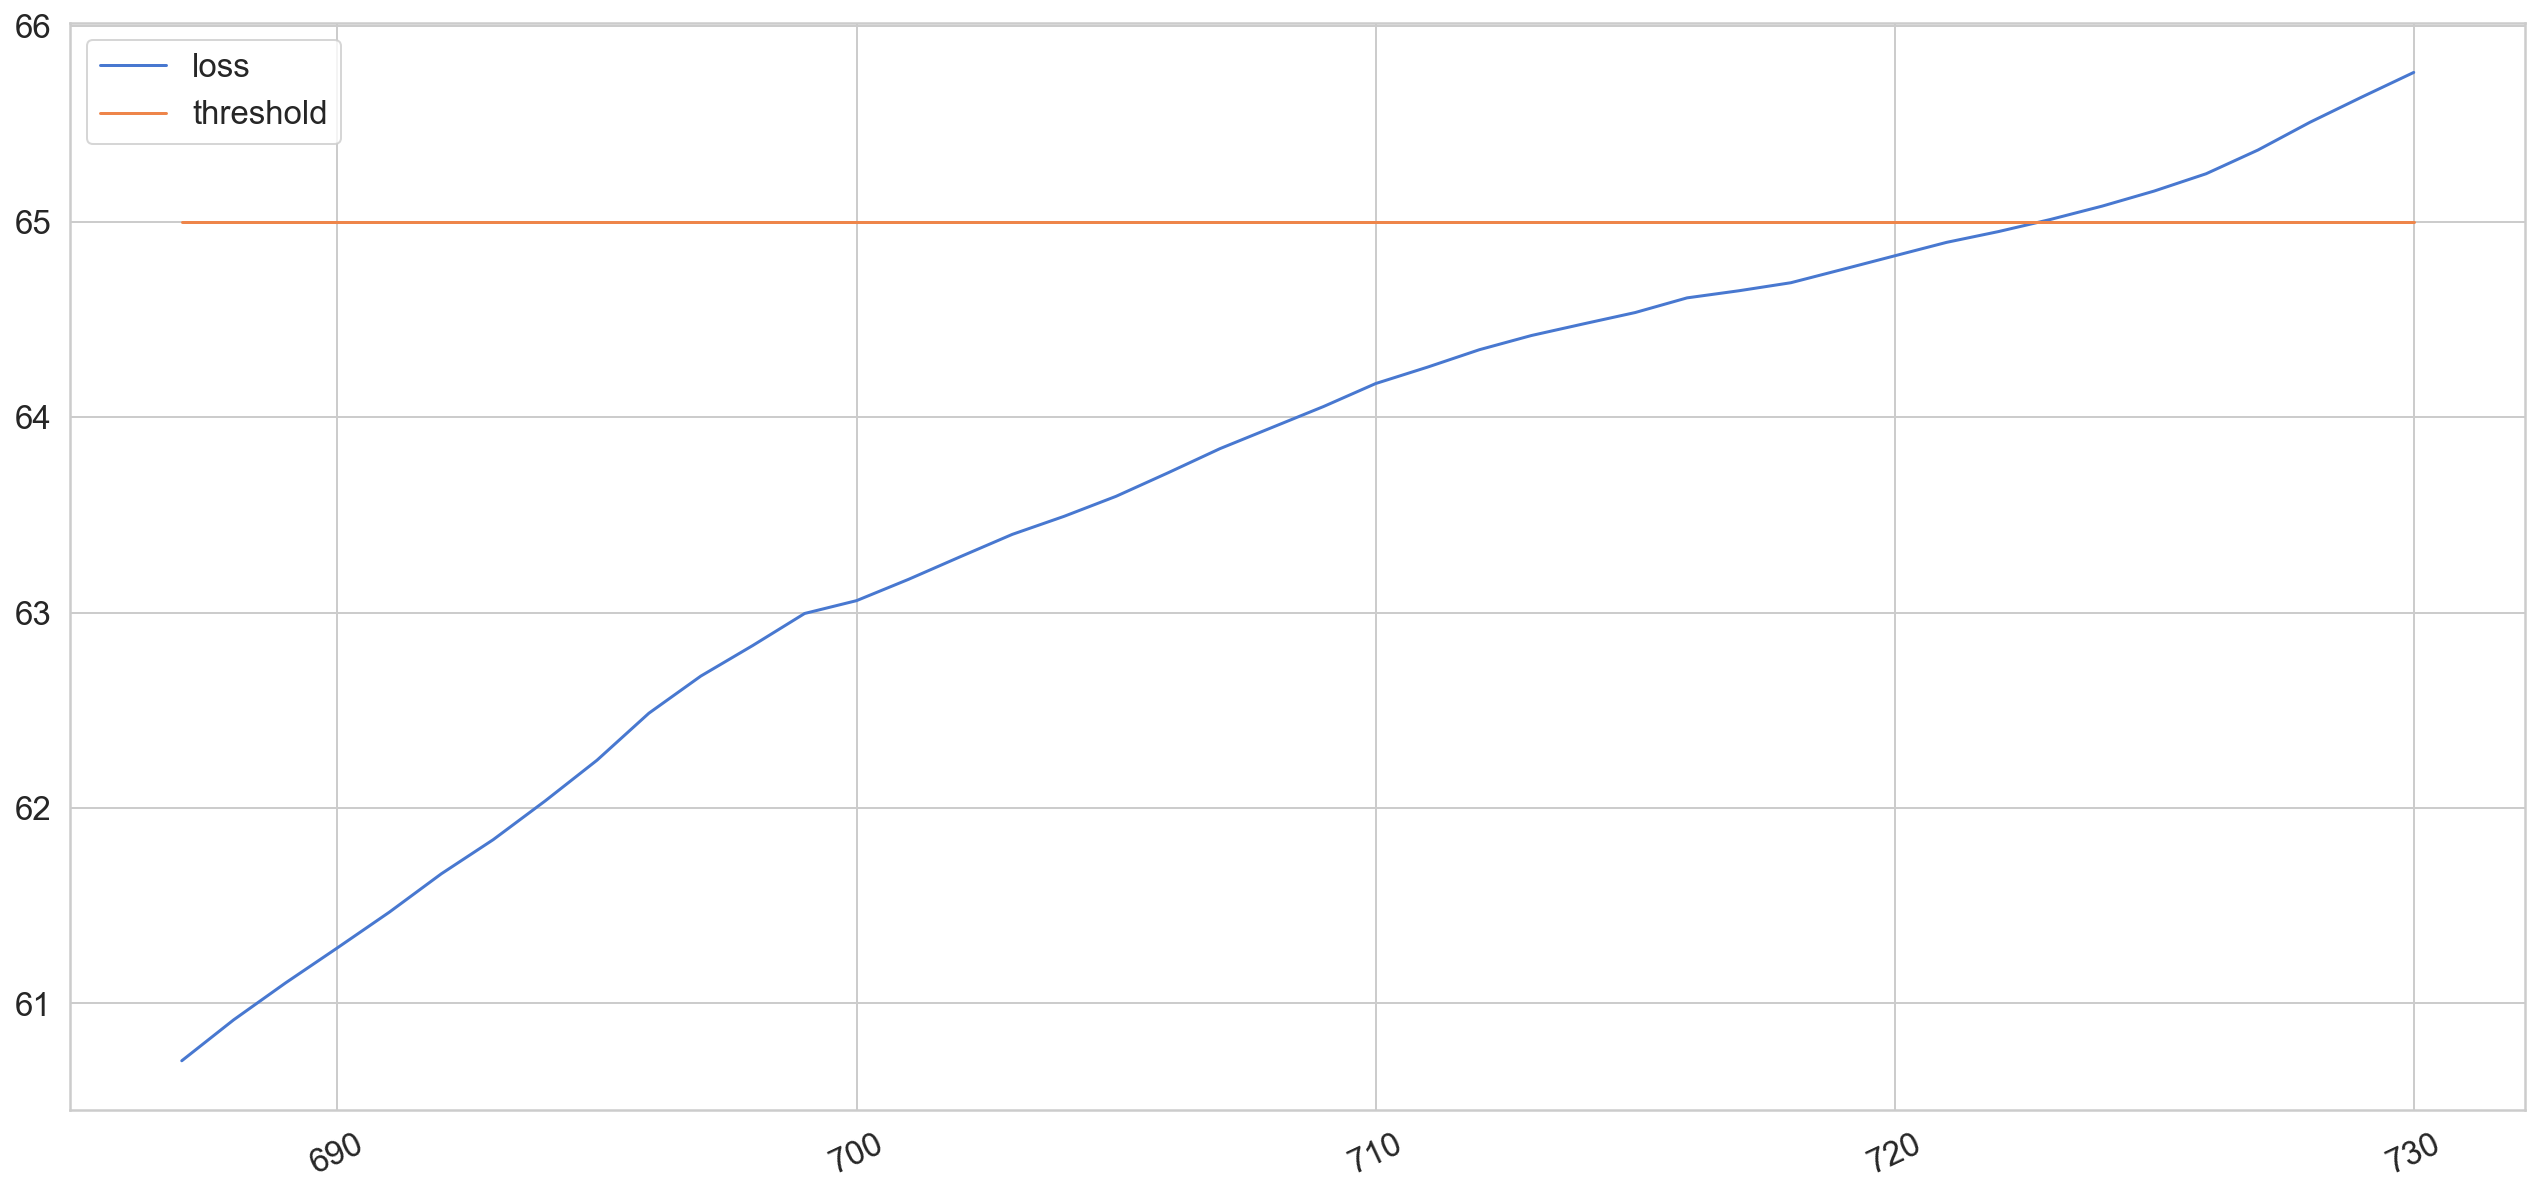

In [14]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [15]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
723,65.011665,65,True,3.554665
724,65.080177,65,True,3.570751
725,65.157135,65,True,3.605847
726,65.245644,65,True,3.583912
727,65.367172,65,True,3.588299


C:\Users\user\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


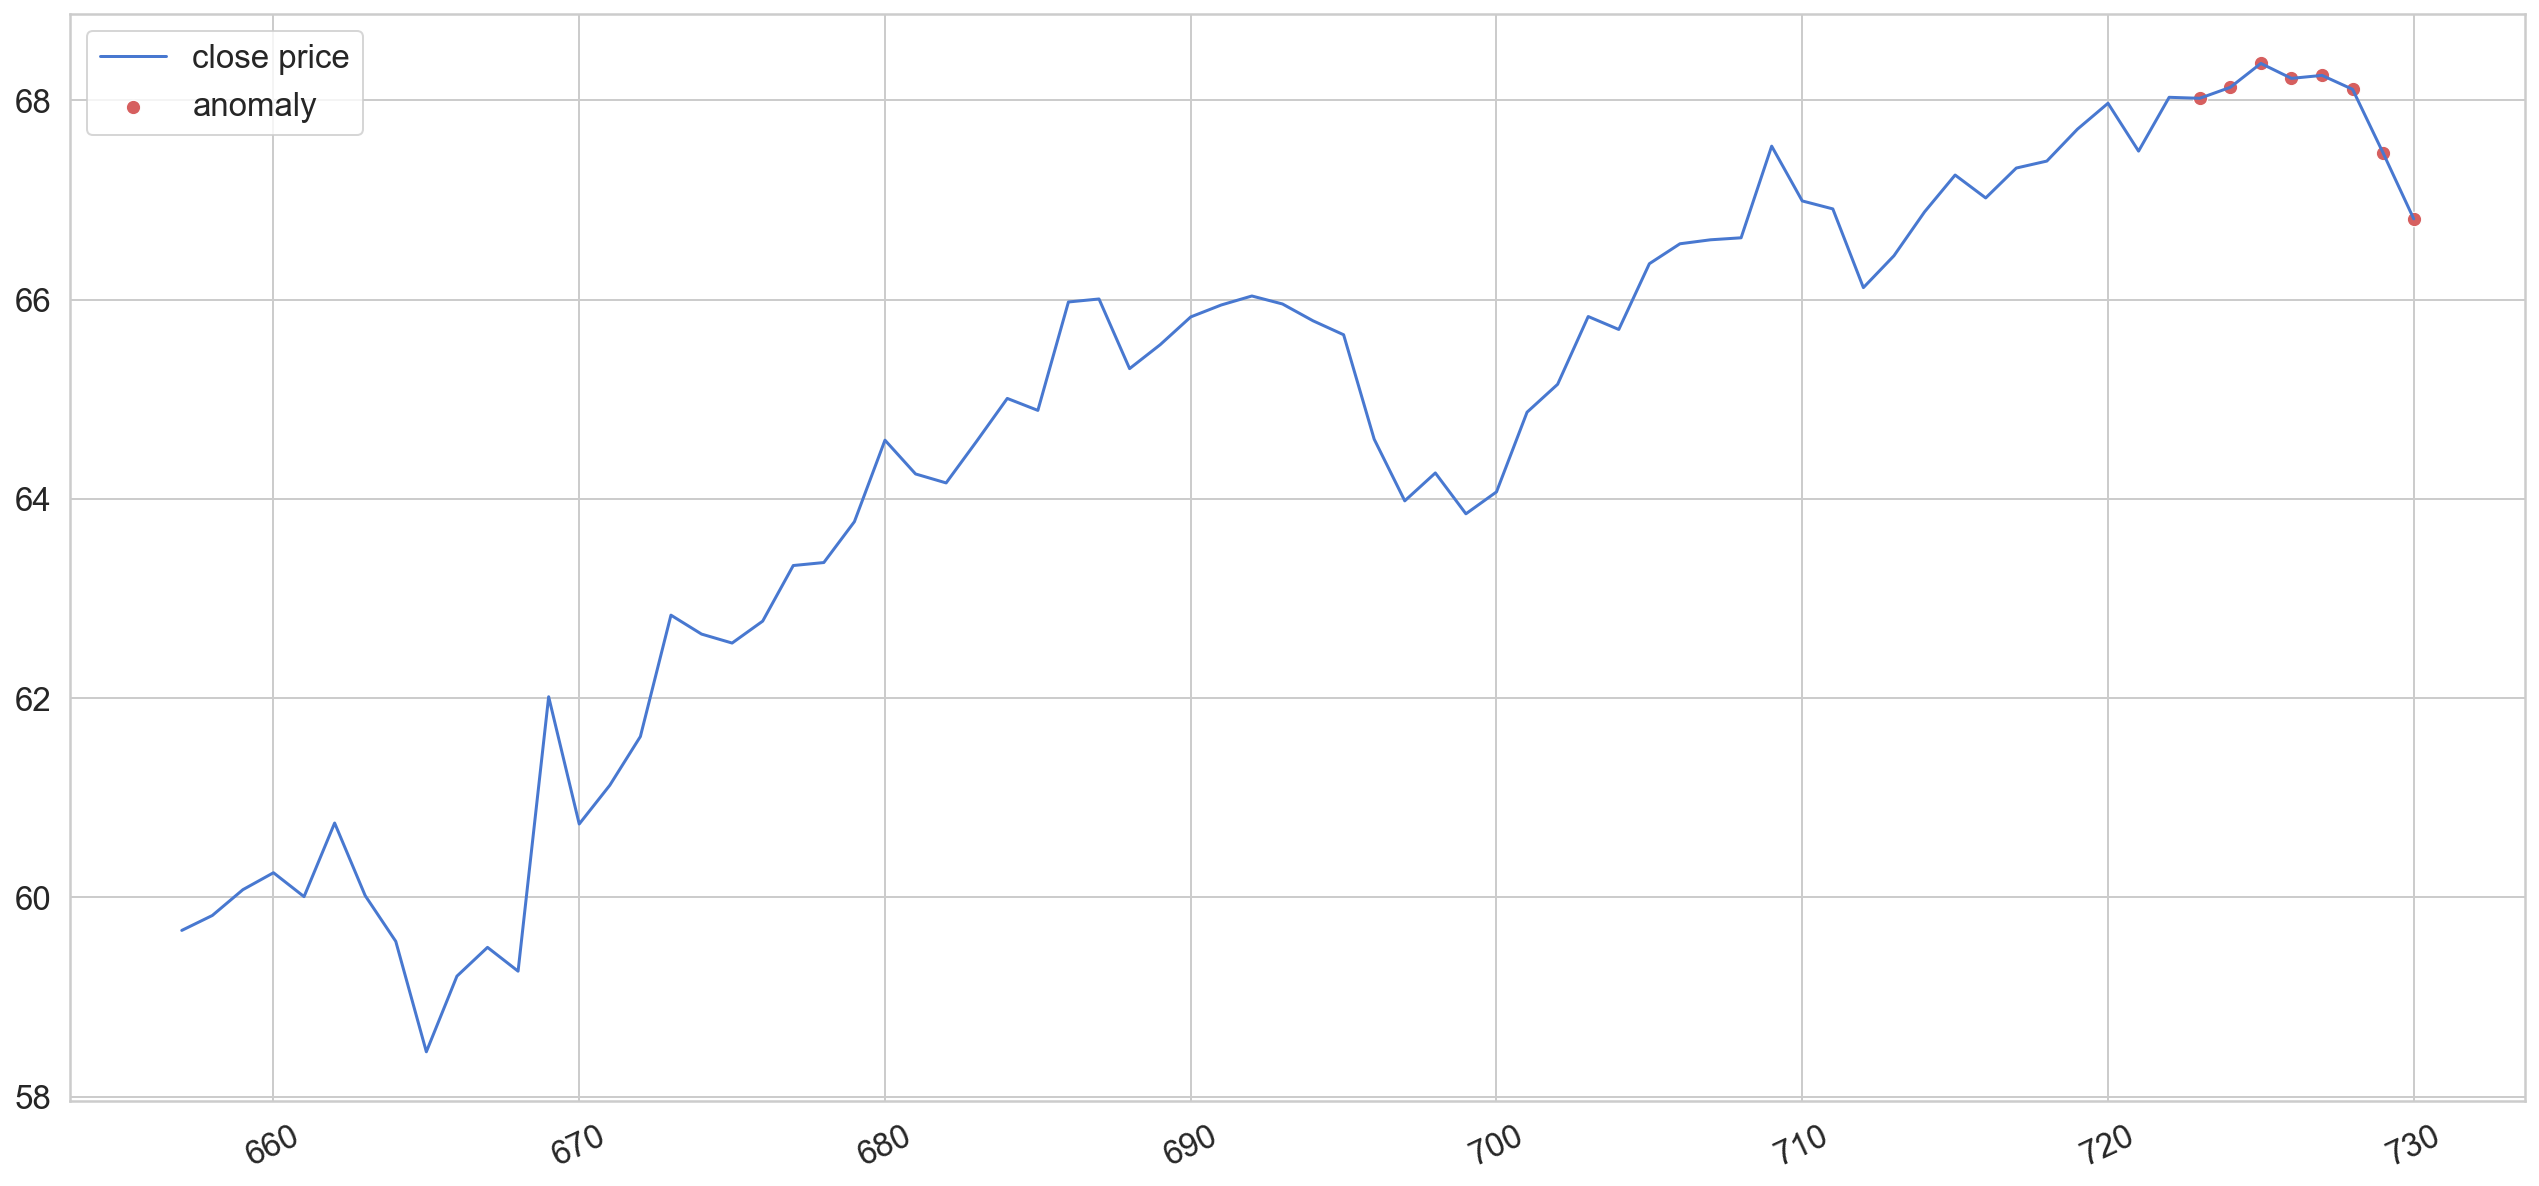

In [16]:
plt.plot(
  time_array[train_size:], 
  scaler.inverse_transform(test_scaled), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();